In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import src
from src.paleoseismic import PaleoseismicCatalog
import os
import yaml
import lifelines
import scipy

# set the figure size and style
dpi = 200
mpl.rc('figure',dpi=dpi)
plt.style.use('tableau-colorblind10')
mpl.rc('font',size=10)

# set the data directory avoiding hardcoding the path
base_dir = Path(src.__file__).parents[1]
data_directory = base_dir/"data"
restults_directory = base_dir/"results"/"scratch"

### Todo:
- [ ] Wrightwood gap is too wide
- [ ] Reflect bootstrap uncertainty in the fit of a sample of the ages


#### Available files records:

In [2]:
[print(f) for f in os.listdir(data_directory / "trench_records") if f.endswith(".txt")];

DSF_Qatar.txt
CSZ_central.txt
SAF_Pallett_Creek.txt
DSF_Beteiha.txt
SAF_Wrightwood.txt
SAF_Frasier_Mountian.txt
SJF_Hog_Lake.txt
AF_Lake_Paringa.txt
ATF_CopperMine10.txt
AF_Hokuri_Creek.txt
CSZ_south.txt
SAF_Noyo_Canyon.txt
SJF_Mystic_Lake.txt


In [3]:
filename = "SAF_Wrightwood.txt"

In [4]:
with open(data_directory / "metadata.yaml", "r") as f:
    meta_data = yaml.safe_load(f)

meta_data[filename]["end_time"] = 2025

trench_catalog = PaleoseismicCatalog(
    data_directory / "trench_records" / filename,
    **meta_data[filename],
)

print(yaml.dump(meta_data[filename], sort_keys=False))

trench_catalog.record.head()

name: Wrightwood
fault: San Andreas Fault
latitude: 34.369444
longitude: -117.667778
start_time: -3000
end_time: 2025
gaps:
- - -1500
  - 500
historic_events:
- 1812
- 1857
notes: Historic events in 1812 and 1857 A.D. Old and young records combined, with
  gap interval removed.
references:
- "Scharer, K. M., Weldon, R. J., Fumal, T. E. & Biasi, G. P. Paleoearthquakes on\
  \ the Southern San Andreas Fault, Wrightwood, California, 3000 to 1500 B.C.: A New\
  \ Method for Evaluating Paleoseismic Evidence and Earthquake Horizons. Bull. Seismol.\
  \ Soc. Am. 97, 1054\u20131093 (2007)."
- "Biasi, G. P., Weldon II, R. J., Fumal, T. & Seitz, G. G. Paleoseismic Event Dating\
  \ and the Conditional Probability of Large Earthquakes on the Southern San Andreas\
  \ Fault, California. Bull. Seismol. Soc. Am. 92, 2761\u20132781 (2002)."



,event,age,PDF,CDF
11,WW350,-2999.5,0.000015,0.000060
12,WW350,-2998.5,0.000020,0.000080
13,WW350,-2997.5,0.000024,0.000104
14,WW350,-2996.5,0.000035,0.000139
15,WW350,-2995.5,0.000037,0.000176


/Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/waiting_time_paradox/src/paleoseismic.py:342: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/waiting_time_paradox/src/paleoseismic.py:342: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


[Text(0, 0.5, 'OxCal age PDF')]

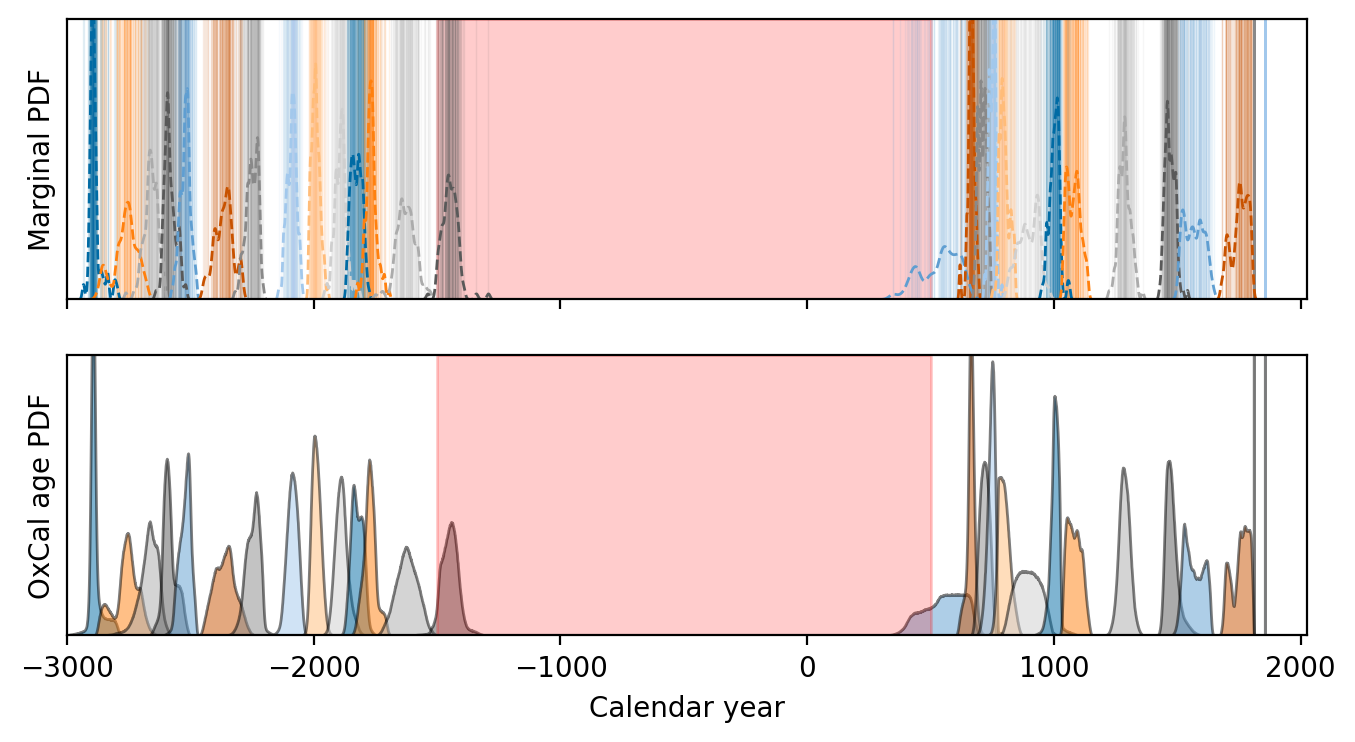

In [6]:
fig, AX = plt.subplots(2, 1, sharex=True, figsize=(8, 4), sharey=True, dpi=200)
trench_catalog.visualize_sampling(ax=AX[0])
AX[0].set(
    yticks=[],
    ylabel="Marginal PDF",
)

trench_catalog.plot_pdfs(AX[1])
AX[1].set(
    ylabel="OxCal age PDF",
)

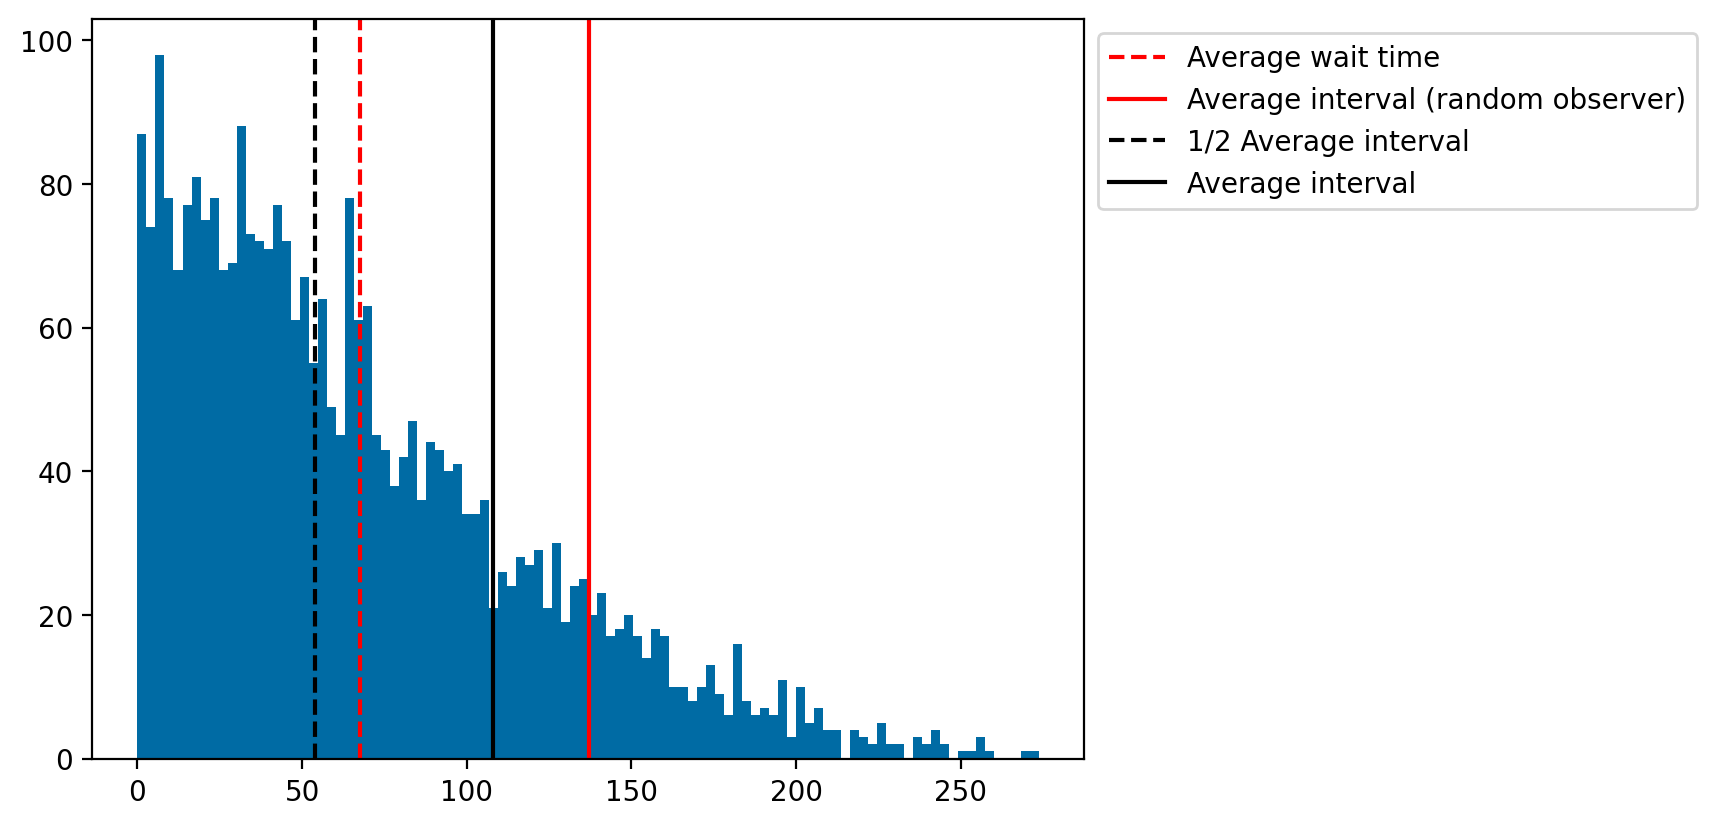

In [7]:
_, waiting_time, lapse_time = trench_catalog.visualize_waiting_time(
    number_of_samples=3000
)

In [ ]:
AX = trench_catalog.visualize_paradox(5000)
AX[1].axvline(2025 - 1857)  # present day interval
AX[1].set(ylim=(0, 5))

In [ ]:
print(
    f"Expect to wait {np.nanmean(waiting_time)/trench_catalog.average_interval:0.2f} of the average interval ({filename})"
)

In [ ]:
last_event = trench_catalog.get_events()[-1]
current_hiatus = 2025 - np.sum(last_event["PDF"] * last_event["age"])

number_of_samples = 1000

# the probability of a the hiatus (or a longer interval) is 1 - cdf, also known as the survival function
S_e = 1 - trench_catalog.ecdf(current_hiatus, number_of_samples, observer="event")
S_r = 1 - trench_catalog.ecdf(current_hiatus, number_of_samples, observer="random")

data = [
    ["Observer Type", "Empirical Probability"],
    ["Event", f"{S_e:0.2f}"],
    ["Random", f"{S_r:0.2f}"],
]

col_widths = [max(len(str(item)) for item in col) for col in zip(*data)]
for row in data:
    print(" | ".join(f"{item:<{col_widths[i]}}" for i, item in enumerate(row)))

#### To do:
   - Fit statistical distribution:
     - Get interevetent time being cautious to include incomplete but observed intervals
     - use lifelines to fit distributions (look into left censored data)
   - Draw random observer probability from long-term samples of the models
   - Compare to analytical prediction from the statistical model
   - Empirical COV vs empirical bias
   - Compare biasi estimate to corrected estimate (both empirical and model derived)
     - Needs one site for each of the following Faults: 
       - San Jacinto fault (SJC): hog lake or mystic lake
       - Southern San Andreas (SSAF): wrightwood
       - Northern San Andreas (NSAF): Noyo
       - Hayward Fault (HF):
       - Elsinore

In [ ]:
t = trench_catalog.sample()  #  note that sampled events cannot be in gaps


In [ ]:
def get_dt(t, trench_catalog):
    dt_list = []
    event_observed_list = []
    t0 = (
        trench_catalog.start_time
        if trench_catalog.start_time > 0
        else min(t) - trench_catalog.minimum_interevent_time
    )
    
    
    for gap in trench_catalog.gaps:
        chunck = [np.atleast_1d(t0)]
        chunck.append(t[t < gap[0]])
        chunck.append(np.atleast_1d(gap[0]))

        chunck = np.concatenate(chunck)

        dt_chunk = np.diff(chunck)
        event_observed_chunk = np.ones_like(dt_chunk)
        event_observed_chunk[0] = 0
        event_observed_chunk[-1] = 0

        dt_list.append(dt_chunk)
        event_observed_list.append(event_observed_chunk)

        t0 = gap[1]
        
    # last chunk
    dt_chunk = np.diff(t[t > t0])
    event_observed_chunk = np.ones_like(dt_chunk)
    event_observed_chunk[0] = 0
    event_observed_chunk[-1] = 0

    dt_list.append(dt_chunk)
    event_observed_list.append(event_observed_chunk)

    dt = np.concatenate(dt_list)
    event_observed = np.concatenate(event_observed_list)
    entry_time = np.ones_like(dt) * trench_catalog.minimum_interevent_time
    
    # really don't know what the best way to handle this is
    dt[dt < trench_catalog.minimum_interevent_time] = trench_catalog.minimum_interevent_time
    
    return dt, event_observed, entry_time


In [ ]:
dt, event_observed, entry_time = get_dt(t, trench_catalog)
fig, ax = plt.subplots(figsize=(7,2), dpi=200)
ax = lifelines.plotting.plot_lifetimes(
    dt,
    event_observed,
    entry_time,
    left_truncated=True,
    event_observed_color="#383838",
    event_censored_color="#383838",
)

ax.set(
    xlabel="Inter-event time (years)",
    ylabel="Sorted intervals",
)

plt.savefig(restults_directory/"lifelines_plot.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(7,1), dpi=200)
[ax.axvline(i_t) for i_t in t]
[ax.axvspan(g1, g2, color='r', alpha=0.2) for g1, g2 in trench_catalog.gaps]
ax.axvspan(trench_catalog.start_time if trench_catalog.start_time > 0 else min(t) - trench_catalog.minimum_interevent_time, trench_catalog.end_time, color="k", alpha=0.2)
ax.set(
    xlabel="Time (years)",
    yticks=[],
)


In [ ]:
weibull_fit = lifelines.WeibullFitter().fit(dt, event_observed=event_observed, entry=entry_time)
exponential_fit = lifelines.ExponentialFitter().fit(dt, event_observed=event_observed, entry=entry_time)
kmf = lifelines.KaplanMeierFitter().fit(dt, event_observed=event_observed, entry=entry_time)


In [ ]:
ax = lifelines.plotting.cdf_plot(weibull_fit)
ax.axhline(0.5, color="k", linestyle="--")
ax.axvline(np.mean(dt[event_observed==1]), color="k", linestyle="--")

In [ ]:

fig, ax = plt.subplots(figsize=(4, 2), dpi=200)

times = np.linspace(0, 400, 100)

# number_of_events = len(trench_catalog.events)
sample_dt_list = []
sample_event_observed_list = []
sample_entry_time_list = []

weibull_survival_function = []
exponential_survival_function = []
lognormal_survival_function = []
empirical_survival_function = []

weibull_AIC = []
exponential_AIC = []
lognormal_AIC = []

weibull_k = []
weibull_lamda = []

number_of_samples_from_trench_catalog = 100

for i in range(number_of_samples_from_trench_catalog):
    sample_earthquake_ages = trench_catalog.sample()
    sample_dt, sample_event_observed, sample_entry_time = get_dt(
        sample_earthquake_ages, trench_catalog
    )
    sample_dt_list.append(sample_dt)
    sample_event_observed_list.append(sample_event_observed)
    sample_entry_time_list.append(sample_entry_time)
    
    fitting_kwards = {
        "durations": sample_dt,
        "entry": sample_entry_time,
        "event_observed": sample_event_observed,
    }

    weibull_fit = lifelines.WeibullFitter().fit(**fitting_kwards)
    exponential_fit = lifelines.ExponentialFitter().fit(**fitting_kwards)
    
    # TODO: Log-normal fit
    lognormal_fit = lifelines.LogNormalFitter().fit(**fitting_kwards)
    
    kmf = lifelines.KaplanMeierFitter().fit(**fitting_kwards)
    
    plot_kwards = dict(
        lw=0.5,
        alpha=0.05,
    )

    ax.plot(times, weibull_fit.survival_function_at_times(times), color="cornflowerblue", **plot_kwards) 
    ax.plot(times, exponential_fit.survival_function_at_times(times), color="y", **plot_kwards)
    ax.plot(times, lognormal_fit.survival_function_at_times(times), color="darkorange", **plot_kwards)
    
    empirical_survival_function.append(kmf.survival_function_at_times(times))
    weibull_survival_function.append(weibull_fit.survival_function_at_times(times))
    exponential_survival_function.append(exponential_fit.survival_function_at_times(times))
    lognormal_survival_function.append(lognormal_fit.survival_function_at_times(times))
    
    weibull_AIC.append(weibull_fit.AIC_)
    exponential_AIC.append(exponential_fit.AIC_)
    lognormal_AIC.append(lognormal_fit.AIC_)
    weibull_k.append(weibull_fit.params_.loc["rho_"])
    weibull_lamda.append(weibull_fit.params_.loc["lambda_"])

mean_survival_function = np.vstack(empirical_survival_function).mean(axis=0)
mean_weibull_survival_function = np.vstack(weibull_survival_function).mean(axis=0)
mean_exponential_survival_function = np.vstack(exponential_survival_function).mean(axis=0)
mean_lognormal_survival_function = np.vstack(lognormal_survival_function).mean(axis=0)


ax.plot(times, mean_weibull_survival_function, color="cornflowerblue", lw=1, alpha=1, label="Weibull")
ax.plot(times, mean_exponential_survival_function, color="y", lw=1, alpha=1, label="Exponential")
ax.plot(times, mean_survival_function, color="k", lw=1, alpha=1, label="Empirical")
ax.axvspan(0, trench_catalog.minimum_interevent_time, color="r", alpha=0.2)


exp_inset_ax = ax.inset_axes([0.5, 0.5, 0.4, 0.2])
diff_AIC = (np.array(exponential_AIC)-np.array(weibull_AIC))/2
bins = np.arange(np.floor(np.min(diff_AIC)), np.ceil(np.max(diff_AIC)), 1)
exp_inset_ax.hist(diff_AIC[diff_AIC<0], bins=bins, histtype="step", color="y")
exp_inset_ax.hist(diff_AIC[diff_AIC>0], bins=bins, histtype="step", color="cornflowerblue")
exp_inset_ax.set(
    yticks=[],
    xlabel=r"Relative likelihood",
)
exp_inset_ax.spines["left"].set_visible(False)
exp_inset_ax.spines["top"].set_visible(False)
exp_inset_ax.spines["right"].set_visible(False)

logn_inset_ax = ax.inset_axes([0.5, 0.75, 0.4, 0.2])
diff_AIC = (np.array(lognormal_AIC)-np.array(weibull_AIC))/2
bins = np.arange(np.floor(np.min(diff_AIC)), np.ceil(np.max(diff_AIC)), 1)
logn_inset_ax.hist(diff_AIC[diff_AIC<0], bins=bins, histtype="step", color="darkorange")
logn_inset_ax.hist(diff_AIC[diff_AIC>0], bins=bins, histtype="step", color="cornflowerblue")
logn_inset_ax.set(
    yticks=[],
    xlim=exp_inset_ax.get_xlim(),
    xticks=[],
)

logn_inset_ax.spines["left"].set_visible(False)
logn_inset_ax.spines["top"].set_visible(False)
logn_inset_ax.spines["right"].set_visible(False)

    
ax.set(
    xlabel="Inter-event time (years)",
    ylabel="Survival function",
    xlim=(0, 400),
)

plt.savefig(restults_directory/"weibull_vs_exponential.pdf")

In [ ]:
lam, k = (
    weibull_fit.params_.loc["lambda_"],
    weibull_fit.params_.loc["rho_"]
)

first_moment = lam * scipy.special.gamma(1 + 1/k)
second_moment = lam**2 * scipy.special.gamma(1 + 2/k)

# print:
print(f"Expected interval time: {first_moment}")
print(f"Random observer: {second_moment/(first_moment*2)}")
print(f"Bias: {(second_moment / (first_moment*2) / (first_moment / 2))}")


In [ ]:
lam, k

In [ ]:

print(f"k: \t{np.mean(weibull_k):0.2f} +/- {np.std(weibull_k):0.2f}")
print(f"lambda:\t{np.mean(weibull_lamda):0.2f} +/- {np.std(weibull_lamda):0.2f}")

In [ ]:
fig, AX = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
weibull_fit.plot_survival_function(ax=AX[0])
exponential_fit.plot_survival_function(ax=AX[0])
kmf.plot_survival_function(ax=AX[0], color="k")
AX[0].set(
    ylabel="Survival Function",
    ylim=(0, 1),
)
weibull_fit.plot_hazard(ax=AX[1])
exponential_fit.plot_hazard(ax=AX[1])
AX[1].set(
    ylabel="Hazard Function",
    xlabel="Inter-event time (years)",
)


### Effect of censoring

In [ ]:
weibull_fit_uncensored = lifelines.WeibullFitter().fit(dt[event_observed==1])

fig, ax = plt.subplots(figsize=(10,3), dpi=200)
loc = slice(0,np.max(dt))
weibull_fit_uncensored.plot_hazard(ax=ax, label="Uncensored", loc=loc)
weibull_fit.plot_hazard(ax=ax, label="Censored", loc=loc)
exponential_fit.plot_hazard(ax=ax, label="Exponential", loc=loc)
ax.set(
    xlabel="Inter-event time (years)",
    ylabel="Hazard Function",
)

In [ ]:
weibull_fit.print_summary()
exponential_fit.print_summary()

In [ ]:
k

In [ ]:

k = weibull_fit.params_.loc["rho_"]
l = weibull_fit.params_.loc["lambda_"]

u = np.random.uniform(0,1, 10000)

sample_intervals = l * (-np.log(1-u))**(1/k)
fig, ax = plt.subplots(figsize=(10,3), dpi=200)
_, edges, _ = ax.hist(sample_intervals, bins=100, density=True)
ax.plot(edges, weibull_fit.density_at_times(edges), color="k")


ax.set(
    xlabel="Inter-event time (years)",
    ylabel="Frequency",
)

t = np.cumsum(sample_intervals)
snip_time = 1000
inset_ax = ax.inset_axes((0.55, 0.6, 0.4, 0.25))
[inset_ax.axvline(t_i, color="k", lw=0.2) for t_i in t[t<snip_time]]
inset_ax.axvspan(t[t<snip_time][-1], snip_time, color="r", alpha=0.2)
inset_ax.set(
    xlim=(0, snip_time),
    yticks=[],
    xticks=[],
)


# remove all top, left and right spines
inset_ax.spines['top'].set_visible(False)
inset_ax.spines['left'].set_visible(False)
inset_ax.spines['right'].set_visible(False)    

full_intervals = np.array([src.stats_utils.get_full_interval(t,tq) for tq in np.random.uniform(0, t[-1], 10000)])
ax.hist(full_intervals, bins=100, density=True, alpha=0.5);

ax.axvline(2025 - 1857, c='r', linestyle='--')

np.mean(full_intervals>100)